In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import swat as sw
import flips
s = sw.CAS('localhost',5570,'sas', 'Orion123')

## Test on single image

In [2]:
def hFlip(data_in, data_out, n_channels, width, height):
    # Create list of indexes in hFlipped order
    cols = list(range(n_channels*width*height))
    for i in range(n_channels):
        for j in range(height):
            for k in range(width//2):
                temp_front = cols[(i*784)+(j*28)+k]
                temp_back = cols[(i*784)+28+(j*28)-1-k]
                cols[(i*784)+(j*28)+k] = temp_back
                cols[(i*784)+28+(j*28)-1-k] = temp_front  
                
    # Create string for retain statement with elements in hFlipped order
    order_string = 'retain'
    for i in range(len(cols)):
        order_string += ' pixel'  + str(cols[i])
    
    # Create new dataset with pixels in new order
    # Gives desired effect of hFlipping 
    sasCode  = 'data ' + data_out + ';\n'
    sasCode += order_string + ';\n'
    sasCode += 'set ' + data_in.name + ';\n'
    sasCode += 'run;'
    r = s.dataStep.runCode(sasCode)
    
    s.droptable(data_in)
    
    return r['OutputCasTables']['casTable'][0]

In [3]:
def vFlip(data_in, data_out, n_channels, width, height):
    # Create list of indexes in hFlipped order
    cols = list(range(n_channels*width*height))
    for i in range(n_channels):
        for j in range(height//2):
            for k in range(width):
                temp_front = cols[(i*784)+(j*28)+k]
                temp_back = cols[(i*784)+len(cols)//4-28*j-28+k]
                cols[(i*784)+(j*28)+k] = temp_back
                cols[(i*784)+len(cols)//4-28*j-28+k] = temp_front
                
    # Create string for retain statement with elements in hFlipped order
    order_string = 'retain'
    for i in range(len(cols)):
        order_string += ' pixel'  + str(cols[i])
    # Create new dataset with pixels in new order
    # Gives desired effect of hFlipping 
    sasCode  = 'data ' + data_out + ';\n'
    sasCode += order_string + ';\n'
    sasCode += 'set ' + data_in.name + ';\n'
    sasCode += 'run;'
    r = s.dataStep.runCode(sasCode)
    
    s.droptable(data_in)
    
    return r['OutputCasTables']['casTable'][0]

In [4]:
x_train= pd.read_csv('data/SAT6/X_train_sat6.csv', header=None, nrows=10, dtype='uint8') # load pixel table 
y_train = pd.read_csv('data/SAT6/y_train_sat6.csv', header=None, nrows=10) # load label table
annotations = pd.read_csv('data/SAT6/sat6annotations.csv', header=None) # load label annotation table

In [5]:
# This returns a list containing the positions of the target variable in the
# one hot encoded vector for each image in our dataset
def reverse_onehot(y):
    l = []
    for row in y:
        m = row.argmax()
        l.append(m)
    return l

In [6]:
y_train_rev = reverse_onehot(y_train.values)

In [7]:
# This returns a dict with keys equal to the class name and 
# values equal to position of the target in a one hot encoded vector
d = {}
for row in annotations.values:
    d[row[0]] = row[1:].argmax()
d

{'barren_land': 1,
 'building': 0,
 'grassland': 3,
 'road': 4,
 'trees': 2,
 'water': 5}

In [8]:
# This returns a list with the label names as opposed to one hot encoded vector 
def assign_label(d,y):
    for idx,row in enumerate(y):
        for k,v in d.items():
            if row == v:
                y[idx] = k
            else:
                continue
    return y

In [9]:
# Create dataframe with single column 'label' 
label_train = pd.DataFrame(assign_label(d, y_train_rev), columns=['_label_'])

In [10]:
label_train.head()

,_label_
0,trees
1,barren_land
2,water
3,water
4,water


In [11]:
# Group channels into (rr,..,gg,..,bb,..,irir..)
def group_channels(x, n_ch=4):
    l = []
    for i in range(n_ch):
        l.append(x.loc[:,i::4]) # Slice through dataframe at r,g,b,ir positons and append to l
    df = pd.concat(l, axis=1) # Join columns and create single df
    df.columns = np.arange(len(df.columns)) # Create sequential column names
    return df

In [12]:
x_train = group_channels(x_train)

In [13]:
# Join pixel tables to label table 
train = x_train.join(label_train)

In [14]:
# Final dataframe which contains all image data and label names for targets
train.head()

,0,1,2,3,4,5,6,7,8,9,...,3127,3128,3129,3130,3131,3132,3133,3134,3135,_label_
0,116,108,67,47,48,44,89,102,97,96,...,165,146,103,122,76,67,80,94,103,trees
1,177,180,181,181,178,176,177,178,181,178,...,174,173,172,172,170,170,171,173,174,barren_land
2,20,27,39,29,23,31,66,66,22,23,...,6,9,7,5,5,6,8,9,12,water
3,102,134,135,128,142,153,151,111,85,65,...,17,13,11,9,8,5,5,6,6,water
4,122,124,135,134,138,136,130,146,139,98,...,19,28,29,30,36,37,34,24,21,water


In [15]:
train_building = train.loc[train['_label_'] == 'building']

In [16]:
train_building

,0,1,2,3,4,5,6,7,8,9,...,3127,3128,3129,3130,3131,3132,3133,3134,3135,_label_
5,229,231,233,230,231,234,232,229,232,234,...,172,178,175,173,182,201,221,230,232,building
6,71,107,194,214,209,205,211,179,205,230,...,138,157,154,152,149,148,147,140,136,building


In [17]:
s.upload_frame(train_building, casout='train')

NOTE: Cloud Analytic Services made the uploaded file available as table TRAIN in caslib CASUSER(sas).
NOTE: The table TRAIN has been created in caslib CASUSER(sas) from binary data uploaded to Cloud Analytic Services.


CASTable('TRAIN', caslib='CASUSER(sas)')

In [18]:
train = s.CASTable('train')
train.head()

,0,1,2,3,4,5,6,7,8,9,...,3127,3128,3129,3130,3131,3132,3133,3134,3135,_label_
0,229.0,231.0,233.0,230.0,231.0,234.0,232.0,229.0,232.0,234.0,...,172.0,178.0,175.0,173.0,182.0,201.0,221.0,230.0,232.0,building
1,71.0,107.0,194.0,214.0,209.0,205.0,211.0,179.0,205.0,230.0,...,138.0,157.0,154.0,152.0,149.0,148.0,147.0,140.0,136.0,building


In [19]:
# Change pixel column names to pixel0-pixel3135
column_dict = [{'name':str(i),'rename':'pixel' + str(i)} for i in range(3136)]
train.altertable('train', columns = column_dict)
train.columninfo()

,Column,ID,Type,RawLength,FormattedLength,NFL,NFD
0,pixel0,1,double,8,12,0,0
1,pixel1,2,double,8,12,0,0
2,pixel2,3,double,8,12,0,0
3,pixel3,4,double,8,12,0,0
4,pixel4,5,double,8,12,0,0
5,pixel5,6,double,8,12,0,0
6,pixel6,7,double,8,12,0,0
7,pixel7,8,double,8,12,0,0
8,pixel8,9,double,8,12,0,0
9,pixel9,10,double,8,12,0,0


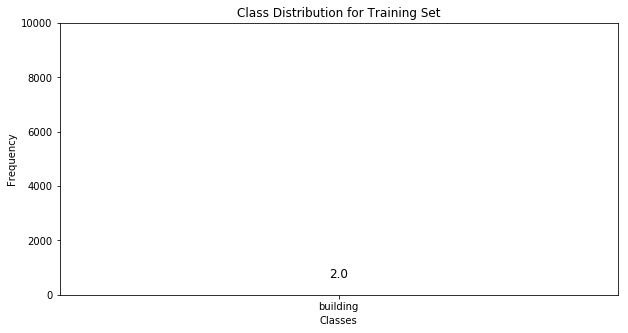

In [20]:
# View class distributions for training set
dist = train.simple.freq(inputs=['_label_'])['Frequency'][['CharVar','Frequency']]
plt.figure(figsize=(10,5))
bar = sns.barplot(x=dist['CharVar'].values, y=dist['Frequency'].values, color='blue', saturation=0.25)
plt.title('Class Distribution for Training Set')
plt.xlabel('Classes')
plt.ylabel('Frequency')

# Annotate bars with freq values
for p in bar.patches:
    bar.annotate(p.get_height(), (p.get_x() + (p.get_width()/2), p.get_height()), ha='center', va='center', 
                 fontsize=12, color='black', xytext=(0,20), textcoords='offset points')
p = bar.set_ylim(0,10000) 

In [21]:
train_building_h_sample = hFlip(s.partition(table=dict(name=train, where='_label_ = "building"'))['casTable'],
                         'train_building_h_sample', 4, 28, 28)

NOTE: Cloud Analytic Services dropped table _T_V4D44ROA_RVTMJKSY_4KEAZNW4H4 from caslib CASUSER(sas).


In [22]:
train_building_v_sample = vFlip(s.partition(table=dict(name=train, where='_label_ = "building"'))['casTable'],
                         'train_building_v_sample', 4, 28, 28)

NOTE: Cloud Analytic Services dropped table _T_F5XRBXNY_GIF3YTKF_HY42KK3DMS from caslib CASUSER(sas).


In [23]:
train_building_h = flips.h_flip(s, s.partition(table=dict(name=train, where='_label_ = "building"'))['casTable'],
                         'train_building_h', 4, 28, 28)

NOTE: Cloud Analytic Services dropped table _T_6BB676RS_ZNWOQ4II_SMMZZVV3AS from caslib CASUSER(sas).


In [24]:
train_building_v = flips.v_flip(s, s.partition(table=dict(name=train, where='_label_ = "building"'))['casTable'],
                         'train_building_v', 4, 28, 28)

NOTE: Cloud Analytic Services dropped table _T_RQWXHADE_QKO3EKBT_QLXGFJLMXS from caslib CASUSER(sas).


In [25]:
train_building_h_sample.head()

,pixel27,pixel26,pixel25,pixel24,pixel23,pixel22,pixel21,pixel20,pixel19,pixel18,...,pixel3116,pixel3115,pixel3114,pixel3113,pixel3112,pixel3111,pixel3110,pixel3109,pixel3108,_label_
0,248.0,249.0,249.0,249.0,249.0,249.0,249.0,249.0,249.0,249.0,...,164.0,166.0,171.0,166.0,166.0,169.0,169.0,165.0,167.0,building
1,229.0,228.0,227.0,225.0,224.0,223.0,223.0,223.0,222.0,223.0,...,190.0,206.0,209.0,203.0,193.0,184.0,178.0,165.0,130.0,building


In [26]:
train_building_h.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel3127,pixel3128,pixel3129,pixel3130,pixel3131,pixel3132,pixel3133,pixel3134,pixel3135,_label_
0,248.0,249.0,249.0,249.0,249.0,249.0,249.0,249.0,249.0,249.0,...,164.0,166.0,171.0,166.0,166.0,169.0,169.0,165.0,167.0,building
1,229.0,228.0,227.0,225.0,224.0,223.0,223.0,223.0,222.0,223.0,...,190.0,206.0,209.0,203.0,193.0,184.0,178.0,165.0,130.0,building


In [27]:
train_building_v_sample.head()

,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,...,pixel2371,pixel2372,pixel2373,pixel2374,pixel2375,pixel2376,pixel2377,pixel2378,pixel2379,_label_
0,228.0,230.0,232.0,229.0,229.0,232.0,231.0,228.0,229.0,232.0,...,234.0,234.0,234.0,234.0,234.0,234.0,234.0,234.0,233.0,building
1,202.0,218.0,218.0,188.0,133.0,119.0,120.0,101.0,82.0,78.0,...,139.0,138.0,140.0,141.0,144.0,148.0,150.0,152.0,158.0,building


In [28]:
train_building_v.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel3127,pixel3128,pixel3129,pixel3130,pixel3131,pixel3132,pixel3133,pixel3134,pixel3135,_label_
0,228.0,230.0,232.0,229.0,229.0,232.0,231.0,228.0,229.0,232.0,...,234.0,234.0,234.0,234.0,234.0,234.0,234.0,234.0,233.0,building
1,202.0,218.0,218.0,188.0,133.0,119.0,120.0,101.0,82.0,78.0,...,139.0,138.0,140.0,141.0,144.0,148.0,150.0,152.0,158.0,building


In [29]:
train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel3127,pixel3128,pixel3129,pixel3130,pixel3131,pixel3132,pixel3133,pixel3134,pixel3135,_label_
0,229.0,231.0,233.0,230.0,231.0,234.0,232.0,229.0,232.0,234.0,...,172.0,178.0,175.0,173.0,182.0,201.0,221.0,230.0,232.0,building
1,71.0,107.0,194.0,214.0,209.0,205.0,211.0,179.0,205.0,230.0,...,138.0,157.0,154.0,152.0,149.0,148.0,147.0,140.0,136.0,building


In [30]:
def ungroup_channels(x):
    l = []
    for i in range(2):
        for j in range(784):
            l.append(x[i,j])
            l.append(x[i,j+784])
            l.append(x[i,j+2*784])
            l.append(x[i,j+3*784])
    return np.asarray(l).flatten()

In [31]:
train_ungrouped = ungroup_channels(train.head().values).reshape(2,28,28,4)

In [32]:
building_h_ungrouped_sample = ungroup_channels(train_building_h_sample.head().values).reshape(2,28,28,4)
building_h_ungrouped = ungroup_channels(train_building_h.head().values).reshape(2,28,28,4)

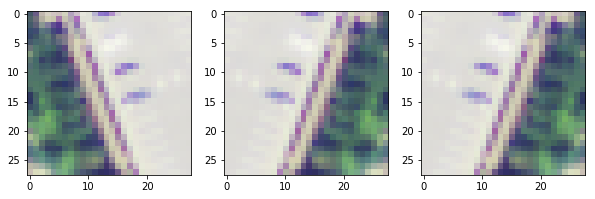

In [33]:
fig, axes = plt.subplots(1, 3,figsize=(10,10))
plt.sca(axes[0])
plt.imshow(train_ungrouped[1][:,:,:3].astype('uint8'))
plt.sca(axes[1])
plt.imshow(building_h_ungrouped_sample[1][:,:,:3].astype('uint8'))
plt.sca(axes[2])
plt.imshow(building_h_ungrouped[1][:,:,:3].astype('uint8'))

In [34]:
building_v_ungrouped_sample = ungroup_channels(train_building_v_sample.head().values).reshape(2,28,28,4)
building_v_ungrouped = ungroup_channels(train_building_v.head().values).reshape(2,28,28,4)

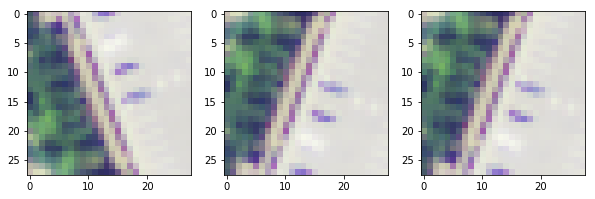

In [35]:
fig, axes = plt.subplots(1, 3,figsize=(10,10))
plt.sca(axes[0])
plt.imshow(train_ungrouped[1][:,:,:3].astype('uint8'))
plt.sca(axes[1])
plt.imshow(building_v_ungrouped_sample[1][:,:,:3].astype('uint8'))
plt.sca(axes[2])
plt.imshow(building_v_ungrouped[1][:,:,:3].astype('uint8'))

In [36]:
[s.droptable(i) for i in s.tableinfo()['TableInfo']['Name']]

NOTE: Cloud Analytic Services dropped table TRAIN from caslib CASUSER(sas).
NOTE: Cloud Analytic Services dropped table TRAIN_BUILDING_H_SAMPLE from caslib CASUSER(sas).
NOTE: Cloud Analytic Services dropped table TRAIN_BUILDING_V_SAMPLE from caslib CASUSER(sas).
NOTE: Cloud Analytic Services dropped table TRAIN_BUILDING_H from caslib CASUSER(sas).
NOTE: Cloud Analytic Services dropped table TRAIN_BUILDING_V from caslib CASUSER(sas).


[+ Elapsed: 0.00261s, user: 0.00247s, sys: 8.2e-05s, mem: 0.266mb,
 + Elapsed: 0.00292s, user: 0.0029s, mem: 0.269mb,
 + Elapsed: 0.00269s, user: 0.00256s, sys: 7.6e-05s, mem: 0.269mb,
 + Elapsed: 0.00237s, user: 0.00145s, sys: 0.000893s, mem: 0.277mb,
 + Elapsed: 0.00249s, user: 0.00239s, sys: 5e-05s, mem: 0.269mb]

In [37]:
s.tableinfo()

NOTE: No tables are available in caslib CASUSER(sas) of Cloud Analytic Services.


+ Elapsed: 0.000602s, mem: 0.28mb

# --------------------------------------------------------------------------------------------------------------- 

## Test on multiple images

In [38]:
x_train= pd.read_csv('data/SAT6/X_train_sat6.csv', header=None, nrows=10000, dtype='uint8') # load pixel table 
y_train = pd.read_csv('data/SAT6/y_train_sat6.csv', header=None, nrows=10000) # load label table
annotations = pd.read_csv('data/SAT6/sat6annotations.csv', header=None) # load label annotation table

In [39]:
# This returns a list containing the positions of the target variable in the
# one hot encoded vector for each image in our dataset
def reverse_onehot(y):
    l = []
    for row in y:
        m = row.argmax()
        l.append(m)
    return l

In [40]:
y_train_rev = reverse_onehot(y_train.values)

In [41]:
# This returns a dict with keys equal to the class name and 
# values equal to position of the target in a one hot encoded vector
d = {}
for row in annotations.values:
    d[row[0]] = row[1:].argmax()
d

{'barren_land': 1,
 'building': 0,
 'grassland': 3,
 'road': 4,
 'trees': 2,
 'water': 5}

In [42]:
# This returns a list with the label names as opposed to one hot encoded vector 
def assign_label(d,y):
    for idx,row in enumerate(y):
        for k,v in d.items():
            if row == v:
                y[idx] = k
            else:
                continue
    return y

In [43]:
# Create dataframe with single column 'label' 
label_train = pd.DataFrame(assign_label(d, y_train_rev), columns=['_label_'])

In [44]:
label_train.head()

,_label_
0,trees
1,barren_land
2,water
3,water
4,water


In [45]:
# Group channels into (rr,..,gg,..,bb,..,irir..)
def group_channels(x, n_ch=4):
    l = []
    for i in range(n_ch):
        l.append(x.loc[:,i::4]) # Slice through dataframe at r,g,b,ir positons and append to l
    df = pd.concat(l, axis=1) # Join columns and create single df
    df.columns = np.arange(len(df.columns)) # Create sequential column names
    return df

In [46]:
x_train = group_channels(x_train)

In [47]:
# Join pixel tables to label table 
train = x_train.join(label_train)

In [48]:
# Final dataframe which contains all image data and label names for targets
train.head()

,0,1,2,3,4,5,6,7,8,9,...,3127,3128,3129,3130,3131,3132,3133,3134,3135,_label_
0,116,108,67,47,48,44,89,102,97,96,...,165,146,103,122,76,67,80,94,103,trees
1,177,180,181,181,178,176,177,178,181,178,...,174,173,172,172,170,170,171,173,174,barren_land
2,20,27,39,29,23,31,66,66,22,23,...,6,9,7,5,5,6,8,9,12,water
3,102,134,135,128,142,153,151,111,85,65,...,17,13,11,9,8,5,5,6,6,water
4,122,124,135,134,138,136,130,146,139,98,...,19,28,29,30,36,37,34,24,21,water


In [49]:
train.shape

(10000, 3137)

In [50]:
s.upload_frame(train, casout='train')

NOTE: Cloud Analytic Services made the uploaded file available as table TRAIN in caslib CASUSER(sas).
NOTE: The table TRAIN has been created in caslib CASUSER(sas) from binary data uploaded to Cloud Analytic Services.


CASTable('TRAIN', caslib='CASUSER(sas)')

In [51]:
train = s.CASTable('train')
train.head()

,0,1,2,3,4,5,6,7,8,9,...,3127,3128,3129,3130,3131,3132,3133,3134,3135,_label_
0,46.0,59.0,60.0,53.0,52.0,51.0,48.0,51.0,72.0,73.0,...,8.0,12.0,11.0,7.0,9.0,13.0,11.0,9.0,7.0,water
1,196.0,168.0,162.0,165.0,198.0,184.0,177.0,175.0,176.0,162.0,...,189.0,194.0,191.0,194.0,196.0,193.0,183.0,190.0,195.0,barren_land
2,133.0,131.0,113.0,125.0,111.0,107.0,127.0,118.0,106.0,130.0,...,190.0,212.0,181.0,192.0,211.0,186.0,165.0,194.0,181.0,grassland
3,172.0,159.0,157.0,169.0,166.0,170.0,181.0,170.0,181.0,176.0,...,183.0,180.0,177.0,185.0,176.0,184.0,175.0,179.0,176.0,barren_land
4,151.0,150.0,148.0,147.0,147.0,149.0,148.0,131.0,109.0,91.0,...,170.0,168.0,164.0,164.0,166.0,163.0,152.0,141.0,139.0,barren_land


In [52]:
# Change pixel column names to pixel0-pixel3135
column_dict = [{'name':str(i),'rename':'pixel' + str(i)} for i in range(3136)]
train.altertable('TRAIN', columns = column_dict)
train.columninfo()

,Column,ID,Type,RawLength,FormattedLength,NFL,NFD
0,pixel0,1,double,8,12,0,0
1,pixel1,2,double,8,12,0,0
2,pixel2,3,double,8,12,0,0
3,pixel3,4,double,8,12,0,0
4,pixel4,5,double,8,12,0,0
5,pixel5,6,double,8,12,0,0
6,pixel6,7,double,8,12,0,0
7,pixel7,8,double,8,12,0,0
8,pixel8,9,double,8,12,0,0
9,pixel9,10,double,8,12,0,0


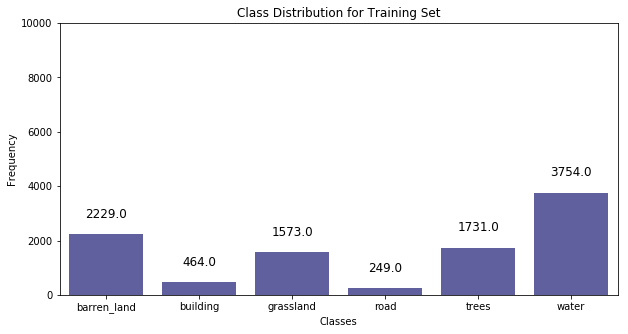

In [53]:
# View class distributions for training set
dist = train.simple.freq(inputs=['_label_'])['Frequency'][['CharVar','Frequency']]
plt.figure(figsize=(10,5))
bar = sns.barplot(x=dist['CharVar'].values, y=dist['Frequency'].values, color='blue', saturation=0.25)
plt.title('Class Distribution for Training Set')
plt.xlabel('Classes')
plt.ylabel('Frequency')

# Annotate bars with freq values
for p in bar.patches:
    bar.annotate(p.get_height(), (p.get_x() + (p.get_width()/2), p.get_height()), ha='center', va='center', 
                 fontsize=12, color='black', xytext=(0,20), textcoords='offset points')
p = bar.set_ylim(0,10000) 

#### Augment on rare cases (building and road)

In [54]:
train_building_h = flips.h_flip(s, s.partition(table=dict(name=train, where='_label_ = "building"'))['casTable'],
                         'train_building_h', 4, 28, 28)

NOTE: Cloud Analytic Services dropped table _T_4WNU5RNQ_KXKI4G2H_N3NB3MBQIJ from caslib CASUSER(sas).


In [55]:
train_building_v = flips.v_flip(s, s.partition(table=dict(name=train, where='_label_ = "building"'))['casTable'],
                         'train_building_v', 4, 28, 28)

NOTE: Cloud Analytic Services dropped table _T_S74VWJ3M_YQOOUWS5_7GSPKFSBBJ from caslib CASUSER(sas).


In [56]:
train_road_h = flips.h_flip(s, s.partition(table=dict(name=train, where='_label_ = "road"'))['casTable'],
                         'train_road_h', 4, 28, 28)

NOTE: Cloud Analytic Services dropped table _T_5KNCPPST_N7JM4TKC_XJ3WRHQQPW from caslib CASUSER(sas).


In [57]:
train_road_v = flips.v_flip(s, s.partition(table=dict(name=train, where='_label_ = "road"'))['casTable'],
                         'train_road_v', 4, 28, 28)

NOTE: Cloud Analytic Services dropped table _T_JWJVCDUV_7BN7RJUF_JUJM7QCWM4 from caslib CASUSER(sas).


In [58]:
s.tableinfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,TRAIN,10000,3137,0,utf-8,2018-08-31T16:26:27+00:00,2018-08-31T16:26:29+00:00,2018-08-31T16:26:48+00:00,UTF8,1.851352e+09,...,0,0,0,,,0,sas,,2018-08-31T16:26:27+00:00,1.851352e+09
1,TRAIN_BUILDING_H,464,3137,0,utf-8,2018-08-31T16:26:42+00:00,2018-08-31T16:26:44+00:00,2018-08-31T16:26:42+00:00,UTF8,1.851352e+09,...,0,0,0,,,0,sas,,,NaN
2,TRAIN_BUILDING_V,464,3137,0,utf-8,2018-08-31T16:26:44+00:00,2018-08-31T16:26:46+00:00,2018-08-31T16:26:44+00:00,UTF8,1.851352e+09,...,0,0,0,,,0,sas,,,NaN
3,TRAIN_ROAD_H,249,3137,0,utf-8,2018-08-31T16:26:46+00:00,2018-08-31T16:26:48+00:00,2018-08-31T16:26:46+00:00,UTF8,1.851352e+09,...,0,0,0,,,0,sas,,,NaN
4,TRAIN_ROAD_V,249,3137,0,utf-8,2018-08-31T16:26:48+00:00,2018-08-31T16:26:50+00:00,2018-08-31T16:26:48+00:00,UTF8,1.851352e+09,...,0,0,0,,,0,sas,,,NaN


In [59]:
train_building_h.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel3127,pixel3128,pixel3129,pixel3130,pixel3131,pixel3132,pixel3133,pixel3134,pixel3135,_label_
0,168.0,146.0,127.0,95.0,79.0,68.0,69.0,76.0,91.0,105.0,...,176.0,179.0,181.0,180.0,171.0,108.0,47.0,46.0,54.0,building
1,220.0,220.0,217.0,210.0,200.0,192.0,192.0,200.0,210.0,217.0,...,34.0,30.0,33.0,33.0,35.0,39.0,42.0,46.0,48.0,building
2,227.0,226.0,225.0,226.0,225.0,226.0,226.0,225.0,226.0,224.0,...,158.0,157.0,158.0,159.0,160.0,158.0,159.0,158.0,158.0,building
3,48.0,43.0,44.0,48.0,52.0,59.0,56.0,65.0,74.0,70.0,...,24.0,28.0,31.0,27.0,59.0,116.0,114.0,91.0,79.0,building
4,223.0,210.0,212.0,223.0,222.0,224.0,234.0,236.0,231.0,229.0,...,201.0,186.0,173.0,176.0,186.0,190.0,199.0,207.0,208.0,building


In [61]:
train_road_h.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel3127,pixel3128,pixel3129,pixel3130,pixel3131,pixel3132,pixel3133,pixel3134,pixel3135,_label_
0,194.0,198.0,195.0,189.0,180.0,169.0,166.0,166.0,158.0,126.0,...,47.0,56.0,56.0,61.0,70.0,72.0,71.0,114.0,120.0,road
1,175.0,177.0,164.0,162.0,172.0,183.0,193.0,191.0,182.0,162.0,...,62.0,44.0,40.0,39.0,40.0,40.0,41.0,46.0,43.0,road
2,160.0,166.0,170.0,163.0,165.0,188.0,194.0,174.0,140.0,102.0,...,18.0,19.0,19.0,20.0,21.0,28.0,34.0,29.0,44.0,road
3,119.0,125.0,131.0,155.0,181.0,172.0,179.0,194.0,187.0,181.0,...,109.0,119.0,140.0,155.0,158.0,152.0,139.0,120.0,101.0,road
4,185.0,177.0,147.0,83.0,43.0,57.0,90.0,120.0,146.0,156.0,...,158.0,173.0,142.0,97.0,89.0,89.0,87.0,91.0,100.0,road


In [62]:
train_building_v.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel3127,pixel3128,pixel3129,pixel3130,pixel3131,pixel3132,pixel3133,pixel3134,pixel3135,_label_
0,107.0,172.0,214.0,227.0,228.0,227.0,225.0,214.0,206.0,200.0,...,153.0,146.0,139.0,139.0,137.0,140.0,144.0,142.0,146.0,building
1,223.0,171.0,168.0,221.0,222.0,198.0,179.0,163.0,150.0,147.0,...,59.0,69.0,74.0,60.0,59.0,56.0,63.0,91.0,76.0,building
2,230.0,239.0,227.0,168.0,147.0,168.0,193.0,181.0,135.0,134.0,...,46.0,47.0,58.0,104.0,137.0,171.0,184.0,179.0,170.0,building
3,243.0,244.0,244.0,245.0,245.0,246.0,246.0,244.0,243.0,243.0,...,199.0,203.0,169.0,110.0,103.0,114.0,149.0,197.0,216.0,building
4,163.0,132.0,151.0,155.0,175.0,189.0,242.0,240.0,221.0,187.0,...,95.0,95.0,115.0,148.0,161.0,158.0,137.0,116.0,125.0,building


In [63]:
train_road_v.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel3127,pixel3128,pixel3129,pixel3130,pixel3131,pixel3132,pixel3133,pixel3134,pixel3135,_label_
0,137.0,93.0,81.0,73.0,92.0,106.0,92.0,90.0,111.0,112.0,...,127.0,107.0,91.0,97.0,91.0,83.0,80.0,82.0,84.0,road
1,146.0,129.0,150.0,171.0,204.0,219.0,216.0,206.0,194.0,170.0,...,114.0,126.0,133.0,125.0,118.0,126.0,132.0,119.0,118.0,road
2,119.0,124.0,122.0,118.0,125.0,132.0,129.0,127.0,140.0,159.0,...,78.0,77.0,76.0,80.0,91.0,105.0,105.0,109.0,120.0,road
3,132.0,127.0,116.0,137.0,147.0,158.0,166.0,139.0,156.0,144.0,...,102.0,97.0,87.0,87.0,93.0,104.0,116.0,133.0,153.0,road
4,221.0,223.0,227.0,231.0,229.0,230.0,223.0,210.0,210.0,211.0,...,33.0,37.0,43.0,39.0,34.0,39.0,39.0,34.0,31.0,road


In [64]:
def ungroup_channels(x):
    l = []
    for i in range(5):
        for j in range(784):
            l.append(x[i,j])
            l.append(x[i,j+784])
            l.append(x[i,j+2*784])
            l.append(x[i,j+3*784])
    return np.asarray(l).flatten()

In [65]:
building_h_ungrouped_sample = ungroup_channels(train_building_h.head().values).reshape(5,28,28,4)

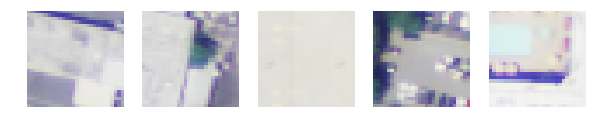

In [66]:
fig, axes = plt.subplots(1, 5,figsize=(10,10))
for x,ax in enumerate(axes.flat):
    ax.imshow(building_h_ungrouped_sample[x][:,:,:3].astype('uint8'))
    ax.axis('off')

In [67]:
road_v_ungrouped_sample = ungroup_channels(train_road_v.head().values).reshape(5,28,28,4)

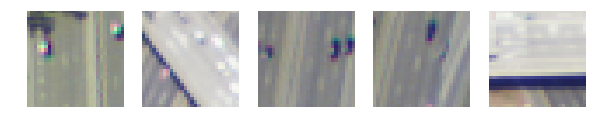

In [68]:
fig, axes = plt.subplots(1, 5,figsize=(10,10))
for x,ax in enumerate(axes.flat):
    ax.imshow(road_v_ungrouped_sample[x][:,:,:3].astype('uint8'))
    ax.axis('off')

#### Append tables to original table

In [69]:
s.tableinfo()['TableInfo'][['Name','Rows']]

,Name,Rows
0,TRAIN,10000
1,TRAIN_BUILDING_H,464
2,TRAIN_BUILDING_V,464
3,TRAIN_ROAD_H,249
4,TRAIN_ROAD_V,249


In [70]:
train.append(train_building_h, casout='train')
train.append(train_building_v, casout='train')
train.append(train_road_h, casout='train')
train.append(train_road_v, casout='train')

data "train";
    set "_PY_T_8612F23D_D756_42AB_A812_25FD96C21579"(caslib="CASUSER(sas)") "_PY_T_15576129_CB61_42F4_8312_D8D87BD72AD7"(caslib="CASUSER(sas)");
run;
data "train";
    set "_PY_T_6600C48A_FAEC_44F3_B207_42E9E6632A52"(caslib="CASUSER(sas)") "_PY_T_8237B83B_207D_45D3_892D_3C328E174FAB"(caslib="CASUSER(sas)");
run;
data "train";
    set "_PY_T_DF433693_70C7_49A3_9A60_176E37688F89"(caslib="CASUSER(sas)") "_PY_T_5609BC49_DD01_4569_94EE_0287B74244CE"(caslib="CASUSER(sas)");
run;
data "train";
    set "_PY_T_25B320F1_EBD0_41E2_AAFD_6733765E70C5"(caslib="CASUSER(sas)") "_PY_T_6AF58508_23D1_463D_9EB4_42A59AE24680"(caslib="CASUSER(sas)");
run;


CASTable('train', caslib='CASUSER(sas)')

In [71]:
s.tableinfo()['TableInfo'][['Name','Rows']]

,Name,Rows
0,TRAIN_BUILDING_H,464
1,TRAIN_BUILDING_V,464
2,TRAIN_ROAD_H,249
3,TRAIN_ROAD_V,249
4,TRAIN,11426


In [72]:
train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel3127,pixel3128,pixel3129,pixel3130,pixel3131,pixel3132,pixel3133,pixel3134,pixel3135,_label_
0,35.0,35.0,32.0,31.0,32.0,30.0,29.0,30.0,32.0,31.0,...,5.0,5.0,6.0,7.0,6.0,6.0,6.0,6.0,7.0,water
1,41.0,49.0,39.0,28.0,29.0,33.0,44.0,56.0,65.0,43.0,...,28.0,23.0,19.0,13.0,13.0,17.0,20.0,12.0,9.0,water
2,120.0,132.0,131.0,126.0,125.0,117.0,120.0,119.0,126.0,115.0,...,190.0,194.0,193.0,196.0,186.0,178.0,185.0,187.0,188.0,grassland
3,75.0,69.0,46.0,43.0,74.0,105.0,97.0,63.0,50.0,65.0,...,10.0,10.0,7.0,7.0,11.0,16.0,23.0,17.0,9.0,water
4,34.0,44.0,40.0,27.0,25.0,27.0,31.0,32.0,29.0,26.0,...,7.0,6.0,5.0,5.0,5.0,5.0,5.0,7.0,8.0,water


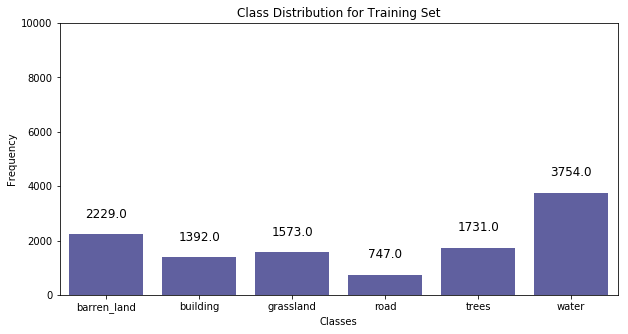

In [73]:
# View class distributions for training set
dist = train.simple.freq(inputs=['_label_'])['Frequency'][['CharVar','Frequency']]
plt.figure(figsize=(10,5))
bar = sns.barplot(x=dist['CharVar'].values, y=dist['Frequency'].values, color='blue', saturation=0.25)
plt.title('Class Distribution for Training Set')
plt.xlabel('Classes')
plt.ylabel('Frequency')

# Annotate bars with freq values
for p in bar.patches:
    bar.annotate(p.get_height(), (p.get_x() + (p.get_width()/2), p.get_height()), ha='center', va='center', 
                 fontsize=12, color='black', xytext=(0,20), textcoords='offset points')
p = bar.set_ylim(0,10000) 